## Advanced Dimensionality Reduction: Discrete Fourier & Wavelet Transforms

#### Misael M. Morales

### Executive Summary
Subsurface spatial data is often very large and difficult to process and utilize in machine learning workflows. Moreover, there tends to be high degrees of correlation and structure in 2D subsurface data, which makes it a perfect candidate for latent structure analysis and modeling. 

Here, we will utilize a 2D multivariate subsurface dataset and demonstrate the usage of the **Discrete Fourier Transform** and the **Discrete Wavelet Transform** to encode the data into the latent space and then reconstruct using a fraction of the original size. DFT works by transforming data into series of sine and cosine functions of increasing frequency to provide an orthogonal basis for the space of solution functions; we can then select only a range of frequencies to maintain that will help explain the data in the reduced dimension. DWT works by retaining frequency and spatial information in a multi-resolution decomposition for space-frequency localization; similarly we can select only a range to maintain and encode information.This leads to a reduced-dimensionality representation of the data, and use this new feature speace to approximately reconstruct our images.

We learn that using DFT/DWT, different latent dimensions will result in different degrees of lossy reconstruction, but that this method is efficient, economic, and simple enough to treat our large data into a reduced dimensionality form. We recommend to use this autoencoder structure whenever dealing with image or volume problems in order to reduce redundancy and increase efficiency of our machine learning workflows.

### Table of Contents
1. Import Packages 
2. Declare Functions 
3. Load & Preprocess Data
        a) MNIST Data 
        b) Subsurface Data

4. Dimensionality Reduction: Discrete Fourier Transform (DFT)
4. Dimensionality Reduction: Discrete Wavelet Transform (DWT)

***

### 1. Import Packages

We start by importing our most basic packages:

In [1]:
%matplotlib inline
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import matplotlib.gridspec as gridspec #enhanced subplot referencing
import tensorflow as tf                #deep learning functionality and MNIST data
import copy                            #create shallow and deep copies

Import other important packages for preprocessing, metrics, etc., and project-specific packages and functions

In [2]:
# Feature Engineering/Preprocessing
from sklearn.preprocessing import StandardScaler              #Standardize variables to mean=0, var=1
from sklearn.preprocessing import MinMaxScaler                #Scale variables to min=0, max=1
from scipy.interpolate import Rbf as Rbf_interpolation        #Inteprolate 2D map from sparse data

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                #Mean squared error (MSE)
from skimage.metrics import structural_similarity as SSIM     #Structural Similarity Index (SSIM)

# Project-specific
from scipy.fft import fft2 as FFT2                            #2D Fast Fourier Transform
from scipy.fft import fftshift as SHIFT                       #Shift fourier frequency to center
from scipy.fft import ifftshift as iSHIFT                     #Inverse Shift fourier frequency to center
from scipy.fft import ifft2 as iFFT2                          #Inverse 2D Fast Fourier Transform
from scipy.fft import dct                                     #Discrete Cosine Transform
from pywt import wavedec2 as DWT2                             #2D Wavelet Transform
from pywt import waverec2 as iDWT2                            #2D inverse Wavelet Transform
from pywt import coeffs_to_array                              #transform pywt coefficients into single array
from pywt import array_to_coeffs                              #transform array of coefficients into pywt type
from skimage.transform import resize as Resize                #resize images

### 2. Delcare Functions
The following functions will be used in the workflow.

In [3]:
# Plot function for sample images
def plot_sample_matrix(samples, my_cmap):
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig  = plt.figure(figsize=(axes, axes))
    gs   = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off'); ax.set_aspect('equal')
        plt.imshow(sample, cmap=my_cmap)

This variable will help us when inserting text boxes into our matplotlib plots

In [4]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

This next function is optional, and will simply be a check that your current version of tensorflow on your Python kernel is running on a GPU and if tensorflow is built with CUDA.

In [5]:
# Check tensorflow GPU settings
print('Tensorflow built with CUDA? ',  tf.test.is_built_with_cuda())
tf.config.list_physical_devices()

Tensorflow built with CUDA?  True


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 3. Load & Preprocess Data

We will deal with two different datasets, both of which need preprocessing.

(1) MNIST dataset: handwritten digits as $28x28$ images from *tensorflow* </br>
(2) Subsurface multivariate data: 2D spatial (sparse) data

### 3. a) MNIST Data

This is a set of $60,000$ images of handwritten digits $0$-$9$. We load it directly from *tensorflow* datasets ([link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist)), and will preprocess to center and flatten as needed for our techniques.

In [6]:
# Load the Dataset and split into train/test
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data()

# Choose to work with ALL or only a few (N) MNIST images (full size is 60,000)
#N = len(x_train_all)
N = 5000
x_train, x_test = x_train_all[:N], x_test_all[:N]
y_train, y_test = y_train_all[:N], y_test_all[:N]

# Normalize the Images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test  = np.expand_dims(x_test/255.0, axis=-1)

# Define the labels
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Print the shapes of the training and testing sets + check that training images are normalized
print('MNIST dataset properties:')
print('Train || Shapes: X={}, Y={} | min={}, max={}'.format(x_train.shape, y_train.shape, x_train.min(), x_train.max()))
print('Test  || Shapes: X={}, Y={} | min={}, max={}'.format(x_test.shape, y_test.shape, x_test.min(), x_test.max()))

MNIST dataset properties:
Train || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0
Test  || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0


In [7]:
# Flatten and Center the images
print('Flattened and Center Images:')

# Flatten the images into NxM array
x_train_f = np.transpose(np.reshape(x_train, [x_train.shape[0], -1]))
x_test_f  = np.transpose(np.reshape(x_test, [x_test.shape[0], -1]))

# Center the Flattened images
x_train_f_c = x_train_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
x_test_f_c  = x_test_f - np.expand_dims(np.mean(x_test_f, axis=1), axis=1)

print('Train || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_train_f_c.shape, y_train.shape, x_train_f_c.min(), x_train_f_c.max()))
print('Test  || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_test_f_c.shape, y_test.shape, x_test_f_c.min(), x_test_f_c.max()))

Flattened and Center Images:
Train || Shapes: X=(784, 5000), Y=(5000,) | min=-0.549, max=1.000
Test  || Shapes: X=(784, 5000), Y=(5000,) | min=-0.531, max=1.000


For improved visualization, we will define a new colormap that uses the 10 individual digits ($0$-$9$) and implement the '*jet*' colormap.

In [8]:
# Define a colormap for the 10-class classification system
import matplotlib.cm as cm
from matplotlib.colors import Normalize
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs      = my_cmap(my_norm(y_train))

Next, we will count the number of items that is in each of the 10 digit categories, and also visualize the first few samples from the training and testing dataset.

In [9]:
# Count the number of occurrences for each digit within the training/testing datasets
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_train[y_train==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count per Digit:')
digit_count.head()

Count per Digit:


,0,1,2,3,4,5,6,7,8,9
Count,479,563,488,493,535,434,501,550,462,495


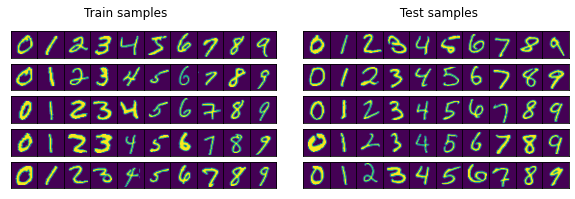

In [10]:
# Visualize a few Train/Test samples from mnist
fig = plt.figure(figsize=(10, 3), constrained_layout=False)
fig.suptitle('Train samples'+60*' '+'Test samples')
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0)

left_grid = outer_grid[0, 0].subgridspec(5, 10, wspace=0, hspace=0)
axs = left_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_train[y_train==d][c]); ax.set(xticks=[], yticks=[])
    
right_grid = outer_grid[0, 1].subgridspec(5, 10, wspace=0, hspace=0)
axs = right_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_test[y_test==d][c]); ax.set(xticks=[], yticks=[])
    
plt.show();

### 3. b) Subsurface Data

The following workflow applies the .csv file 'spatial_nonlinear_MV_facies_v1.csv', a synthetic dataset calculated with geostatistical cosimulation by Dr. Michael Pyrcz, The University of Texas at Austin. The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets)  

From this site, other datasets can also be used for this workflow including but not limited to: {'spatial_nonlinear_MV_facies_v5.csv', 'sample_data_MV_biased.csv', 'PGE383_Dataset_13_Wells.csv', '12_sample_data.csv'}.

We will work with the following features:

* **X** and **Y** - the sptial coordinates (in meters) for the subsurface data
* **Porosity** - fraction of rock void in units of percentage
* **Permeability** - ability of a fluid to flow through the rock in milliDarcy
* **Acoustic Impedence** - product of sonic velocity and rock density (in $kg/m^2s*10^3$)
* **Facies** - binary indicator of sand or shale facies

In [11]:
# Select a subsurface Dataset for image reconstruction
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df.head() #visualize first few rows of the DataFrame

,X,Y,Porosity,Perm,AI,Facies
0,1.219681,10.006391,7.791849,332.802662,4114.121592,1
1,1.400597,160.265186,16.708829,505.072608,3820.596087,1
2,15.497048,775.834642,12.430224,404.367985,4180.556194,1
3,15.642437,446.832057,5.269760,196.557726,5399.358427,0
4,15.873019,476.372378,5.662789,333.942714,4055.169132,1


We perform normalization of the features by applying Min-Max Scaler of the features such that:

$$ x^* = \frac{x-min(x)}{max(x)-min(x)} $$

where $min(x)$ and $max(x)$ are the minimum and maximum values for each of the features in the dataset.

This is done by the *scikitlearn* built-in function
``` python
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
scaled_array   = standard_scaler.fit_transform(float_array)
```

In [12]:
scaler = MinMaxScaler()                   #instantiate the normalization function
df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  #apply standard scaling
df_s.describe().T                           #show summary statistics of the new DataFrame

,count,mean,std,min,25%,50%,75%,max
X,457.0,0.539901,0.293454,0.0,0.298525,0.576053,0.790115,1.0
Y,457.0,0.519437,0.285332,0.0,0.289513,0.530998,0.773822,1.0
Porosity,457.0,0.450309,0.204280,0.0,0.295265,0.460446,0.583979,1.0
Perm,457.0,0.337283,0.190681,0.0,0.212090,0.344085,0.449092,1.0
AI,457.0,0.244481,0.166249,0.0,0.131160,0.205038,0.307400,1.0
Facies,457.0,0.787746,0.409352,0.0,1.000000,1.000000,1.000000,1.0


For simplicity, we specifically name our subsurface features/properties.

We also specifically name the *matplotlib* colormaps that we want to use for each of the feautures/properties.

In [13]:
features = ['Porosity','Perm','AI','Facies']       # names of our features
my_maps  = ['magma', 'jet', 'seismic', 'viridis']  # names of the corresponding colormaps

However, this is a **sparse** dataset of the subsurface, with 457 wells in approximately $1 km^2$ area of the subsurface. Therefore, we must interpolate the spatial properties so that we obtain a full image of the subsurface properties. 

The 2D interpolation is done through *scipy*'s RBF interpolation function. This generates radial basis function inteprolation from $(N,D)$ arrays to an $(M,D)$ domain.

We will interpolate the subsurface 2D data into $(28,28)$ images. These are the standard dimensions of the MNIST dataset, a generic dataset of handwritten digits that we will use later for our workflow.

In [14]:
# Interpolate spatial properties
ti = np.linspace(start=0, stop=1, num=28) #an array of 28 discrete points
XI, YI = np.meshgrid(ti,ti)               #a mesh of 28x28 discrete points
ZI = {}; ZI_s = {}                    

for i in features:
    # RBF interpolation
    ZI[i] = Rbf_interpolation(df_s['X'], df_s['Y'], df[i], function='thin_plate')(XI, YI)[::-1]
    # Normalize our interpolated features 
    ZI_s[i]  = scaler.fit_transform(ZI[i])

for i in np.arange(len(features)):
    print('Standard '+features[i]+': Shape={}, min={:.3f}, max={:.3f}'.format(ZI_s[features[i]].shape,
                                                                               ZI_s[features[i]].min(), 
                                                                               ZI_s[features[i]].max()))

Standard Porosity: Shape=(28, 28), min=0.000, max=1.000
Standard Perm: Shape=(28, 28), min=0.000, max=1.000
Standard AI: Shape=(28, 28), min=0.000, max=1.000
Standard Facies: Shape=(28, 28), min=0.000, max=1.000


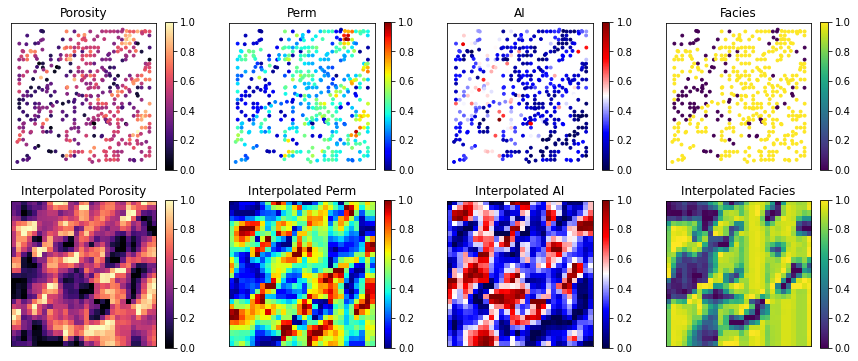

In [15]:
fig, axs = plt.subplots(2,4, figsize=(15,6))
for i in range(len(features)):
    axs[0,i].set_title(features[i]); axs[1,i].set_title('Interpolated '+features[i])
    # plot original data scatterplots
    im1 = axs[0,i].scatter(x=df_s['X'], y=df_s['Y'], vmin=0, vmax=1, s=8, c=df_s[features[i]], cmap=my_maps[i])
    fig.colorbar(im1, ax=axs[0,i])
    # plot interpolated images
    im2 = axs[1,i].imshow(ZI_s[features[i]], vmin=0, vmax=1, cmap=my_maps[i])
    fig.colorbar(im2, ax=axs[1,i])
    # remove ticks, set square box ratios
    for k in range(2):
        axs[k,i].set_xticks([]); axs[k,i].set_yticks([]); 
        axs[k,i].set_aspect('equal', adjustable='box')
plt.show();

Select one of the subsurface features to be used in the remainder of the notebook for image reconstruction.

In [16]:
# Select one of the subsruface features to work with
feature_selected = 'AI'

***

### Advanced Dimensionality Reduction

Dimensionality Reduction is quite ubiqutuous in modern machine learning. The Discrete (Fast) Fourier Transform and the Discrete Wavelet Transform have been widely-studied and applied in theoretical and applied setting for data science, including reservoir characterization, modeling, and simulation. Through DFT and DWT, we can obtain an orthogonal basis in a frequency domain to provide a generic basis functions for the reduced-dimension data; with DWT we also preserve local information through a multi-resolution decomposition in frequency and space. This will reduce the number of vectors to still preserve majority of the information and with this, we can project our 2D data onto the vectors and work in latent space.

Another consideration is the idea of using the latent space for a generic dataset as the basis for reconstruction of a more complex dataset. For instance, using the DFT/DWT projection of the $60,000$ MNIST images, we can reconstruct our 2D subsurface maps from a latent represenation!
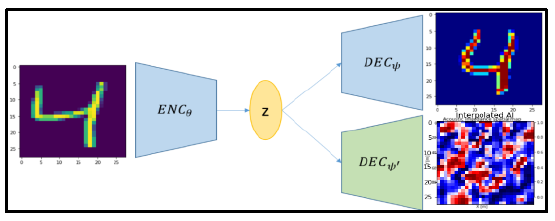

### 4. Discrete Fourier Transform

Unlike data-driven transforms that require large amounts of data to learn basis functions to encode and decode (SVD, PCA), classical or geometric techniques allow to decompose the data matrix into a set of specified basis with different weights. These serve as the reconstruction pattern for the compression and decompression of data. 

While SVD and PCA use the leading eigenvectors of the covariance matrix to reconstruct data, Fourier-based transform (including Wavelets) will generate a set of harmonics from the eigenvectors of the circulant matrices to encode data. These are related to the geometry of infinite-dimensional functions in space, and often represented by a finite sequence of terms. 

The Hermitian inner product for function is given by:
$$ \langle f(x),g(x)\rangle = \int_{a}^{b} f(x) \bar g(x) dx $$

And for vectors of data we have:
$$ f = \begin{pmatrix} f_1 & f_2 & \cdots & f_n \end{pmatrix}^T , g = \begin{pmatrix} g_1 & g_2 & \cdots & f_n \end{pmatrix}^T  \\
   \langle f,g \rangle = g^*f = \sum_{k=1}^{n}f_k\bar g_k  = \sum_{k=1}^{n} f(x_k) \bar g(x_k)      $$

Thus, adding more data points will increase the magnitude of the inner product. 

Similarly, we can compute the Riemman approximation where the limit $n \rightarrow \infty , \Delta x \rightarrow 0$ is the vector inner product which converges continuous functions inner product.
$$ \frac{b-a}{n-1} \langle f,g \rangle = \sum_{k=1}^{n} f(x_k) \bar g(x_k) \Delta x 
   \\ \Delta x = \frac{b-a}{n=1} $$

With these tools, we can project a function into a new coordinate system by a basis of orthogonal functions; and in our case, the Fourier Transform uses $sine$ and $cosine$ basis. The set of $2-\pi$ periodic functions is defined as:
$$ f(x) = \frac{a_0}{2} + \sum_{k=1}^{\infty}[a_k cos(kx) + b_k sin(kx)] $$
where
$$ a_k = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x)cos(kx)dx \quad \& \quad b_k = \frac{1}{\pi} \int_{-\pi}^{pi} f(x)sin(kx)dx $$

The Fourier basis ${cos(kx), sin(kx)}_{k=0}^{\infty}$ yield the projections:
$$ a_k = \frac{\langle f(x),cos(kx) \rangle}{||cos(kx)||^2} \quad \& \quad b_k = \frac{\langle f(x), sin(kx)}{||sin(kx)||^2} $$
where the norms $(||cos(kx)||^2=||sin(kx)||^2=\pi)$ are given by integrating the functions $\cos^2(x)$ and $\sin^2(x)$ in $[-\pi,\pi]$.

With this, we can obtain the Discrete Fourier Transform, given by:
$$ DFT: \hat f_k = \sum_{j=0}^{n-1} f_j e^\frac{-2\pi i jk}{n}  \quad \& \quad iDFT: f_k = \frac{1}{n} \sum_{j=0}^{n-1} \hat f_j e^\frac{2\pi i jk}{n}        $$

It is also noteworthy to list the properties of the Fourier and Inverse Fourier transform: (1) the derivative of a function relates to an increase in order of the Fourier transform, (2) the Fourier Transform is a linear operator, (3) the $L_2$-norm is preserved in transform space, (4) DFT involves a dense matrix multiplication of the order $\mathcal{O}(n^2)$ while FFT is $\mathcal{O}(n \bullet log(n))$

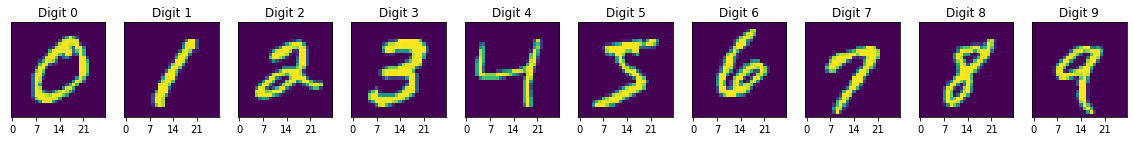

In [17]:
# Convert MNIST to single channel and normalize
x_train_gsc = np.squeeze(x_train)
x_test_gsc  = np.squeeze(x_test)

# Flatten training data
x_train_gsc_f = x_train_gsc.reshape(x_train_gsc.shape[0], 28*28)

# Plot the first instance of each digit from the Training set
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(1,len(np.unique(y_train)),i+1)
    plt.imshow((x_train_gsc[y_train==i][0]), vmin=0, vmax=1, cmap='viridis')
    plt.title('Digit %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

We compute the Fast Fourier Transform for the MNIST dataset, and plot the first representation for each of the 10 digits after Shifting to the center.

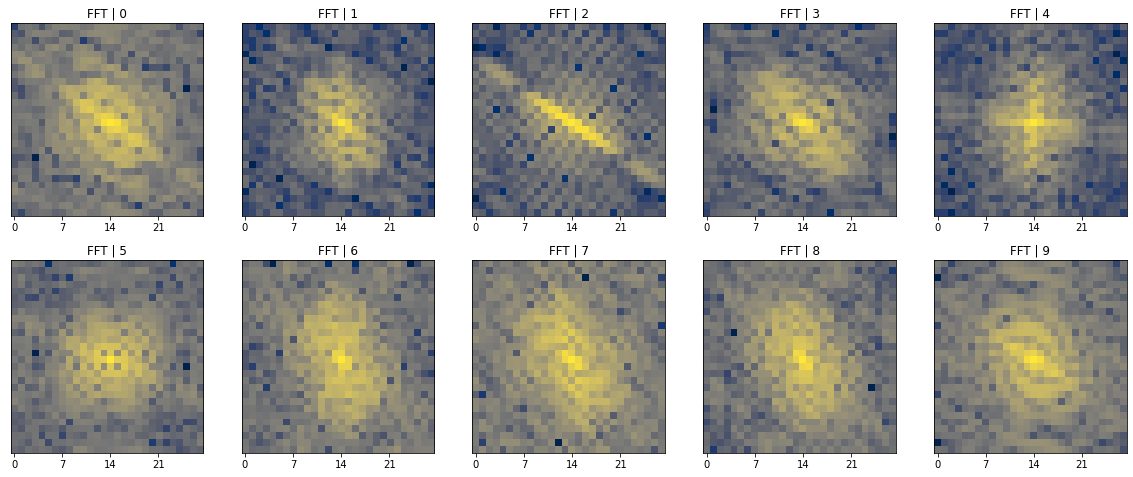

In [18]:
# Compute FFT and shift frequency components to center of the spectrum
x_train_fft2   = FFT2(x_train_gsc)
x_train_fft2_s = SHIFT(x_train_fft2)

# Plot the Shifted (center) FFT frequencies for each digit
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(2,int(len(np.unique(y_train))/2),i+1)
    plt.imshow(np.log10(np.abs(x_train_fft2_s[y_train==i][0])**2), cmap='cividis')
    plt.title('FFT | %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

Seeing that DFT is a computationally expensive operation and that we can choose to retain only a fraction of the basis in order to reconstruct our data, we choose to only retain the $8\times8$ matrix at the center of our $28\times28$ MNIST images. This allows for a compression of approximately one-third the fraction of the original size.

Start=10, End=18


C:\Users\Misael Morales\AppData\Local\Temp\ipykernel_39552\1072340680.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(x_train_fft2_c[y_train==i][0])**2), cmap='cividis')


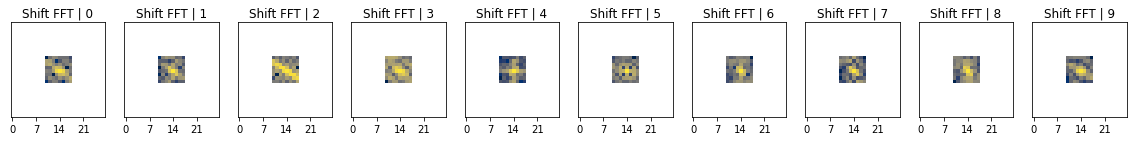

In [19]:
# Define a retention matrix (n-by-n) at the center of the 28x28 image
retain_dim    = 8
train_samples = x_train.shape[0]
center        = x_train.shape[1]
start, end    = int(center/2-retain_dim/2), int(center/2+retain_dim/2)
print('Start={}, End={}'.format(start,end))

# Create a matrix with all zeros except for central (n-by-n) square retained
x_train_fft2_c = np.zeros((train_samples,28,28), dtype=np.complex_)
x_train_fft2_c[:, start:end, start:end] = x_train_fft2_s[:, start:end, start:end]

# Plot the RETAINED, shifted FFT frequencies for each digit
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(1,len(np.unique(y_train)),i+1)
    plt.imshow(np.log10(np.abs(x_train_fft2_c[y_train==i][0])**2), cmap='cividis')
    plt.title('Shift FFT | %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

Using the compressed Fourier representation of the MNIST digits, we then perform the Inverse Fourier Transform and obtain the reconstructed (approximate) images for each of the images.

In [20]:
# Inverse-shift the centered latent-space representations
x_train_fft2_is  = iSHIFT(x_train_fft2_c) 

# Compute inverse FFT
x_train_fft2_i   = iFFT2(x_train_fft2_is)
x_train_fft2_img = x_train_fft2_i.real

# Flatten and store final 28x28 reconstructed images
x_train_fft2_i_f = x_train_fft2_img.reshape(x_train_fft2_i.shape[0],-1)
x_train_fft2_hat = x_train_fft2_img

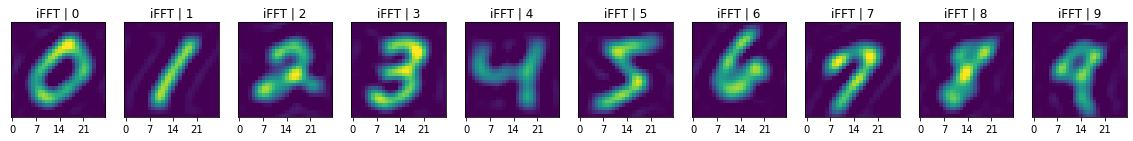

In [21]:
# Plot the first instance of each digit from the inverse FFT reconstruction
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(1,len(np.unique(y_train)),i+1)
    plt.imshow((x_train_fft2_hat[y_train==i][0]), vmin=0, vmax=1, cmap='viridis')
    plt.title('iFFT | %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

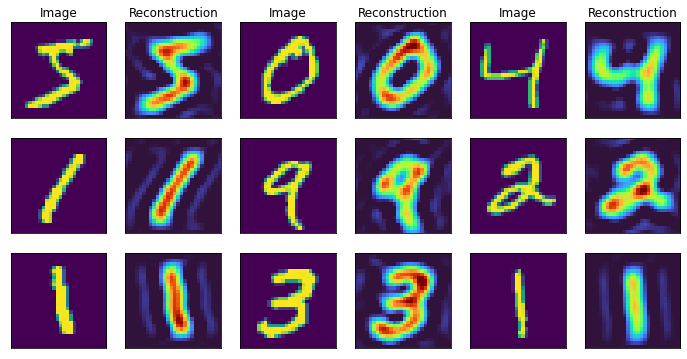

In [22]:
# Visualize a few of the reconstructed samples from MNIST
num_rows, num_cols = 3, 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_gsc[i], vmin=0, vmax=1, cmap='viridis')
    if i < 3: plt.title('Image')
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_fft2_hat[i], vmin=0, vmax=1, cmap='turbo')
    if i < 3: plt.title('Reconstruction')
plt.show();

We now have predicted images $\hat{x}$ for our MNIST dataset. Essentially, the decoded images from a truncated latent represenation obtained from DFT.

We will visualize these reconstructed images, and compare their quality by means of pixel-wise MSE and SSIM. Where:
    $$ MSE = \frac{1}{n} \sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2$$
and
    $$ SSIM(x,y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma^2_x+\sigma^2_y+c_2)}$$
where $y_i$ are the true images and $\hat{y}_i$ are the reconstructed images for the MSE computation. On the other hand, we have that for SSIM, $x$ and $y$ are the two images to be compared, and $c_1 = (k_1L)^2$ and $c_2=(k_2L)^2$ are two variables to stabilize the division with weak denominators. Usually, $k_1=0.01$ and $k_2=0.03$, and $L=2^{(\#bits/pixel)}-1$ typically.

For MSE calculation, we will use the flattened, centered arrays $N \times M$ as opposed to the images $N \times (M,D)$ used in the SSIM calculation.

In [23]:
# Error metrics for selected level of k
mse  = mean_squared_error(x_train_gsc_f, x_train_fft2_i_f)
ssim = SSIM(x_train_gsc, x_train_fft2_hat)
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.023 | SSIM=0.808


We observe a very small MSE and an SSIM above $80%$ when using just an $8\times8$ representation of our $28\times28$ MNIST images!

***

**Subsurface DFT**

Next, we will use the Fast Fourier Transform on the subsurface maps. We also experiment with reducing the latent dimension by only conserving a portion of the Fourier basis and the impact on the image reconstruction from the reduced dimension latent space.

Original Shape: (28, 28)
Flattened Shape: (784, 1)


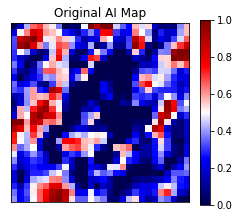

In [24]:
img_gsc     = ZI_s[feature_selected]
img_gsc_f   = np.reshape(img_gsc, (28*28,1))                                 #flatten
img_gsc_f_c = img_gsc_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1) #center

dim1, dim2 = img_gsc.shape
print('Original Shape:', img_gsc.shape)
print('Flattened Shape:', img_gsc_f_c.shape)

# Plot the processed 2D map
plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(img_gsc_f_c, (28, 28)), vmin=0, vmax=1,
           cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map'); plt.xticks([]); plt.yticks([])
plt.colorbar(shrink=0.85)
plt.show();

For the full subsurface feature map, we perform FFT and shift to center. Below we see the results of the FFT representation and the Shifted FFT representation. 

In [25]:

# compute 2D FFT (column-wiseFFT(row-wiseFFT(image)))
img_fft2 = FFT2(img_gsc)

# shift the zero-frequency component to the center of the spectrum. 
img_fft_shift = SHIFT(img_fft2)

# reverse shift 
img_fft_ishift = iSHIFT(img_fft_shift)

# reconstruct the full image from the FFT
img_ifft2 = iFFT2(img_fft_shift)

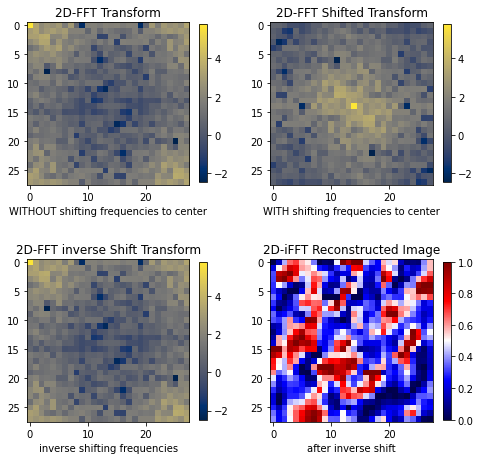

In [26]:
# plot the DFT (2D FFT) Transform (w/out centering)
plt.figure(figsize=(8,8))

cmap = 'cividis'
plt.subplot(221)
plt.imshow(np.log(np.abs(img_fft2)), cmap=cmap)
plt.title('2D-FFT Transform')
plt.xlabel('WITHOUT shifting frequencies to center')
plt.colorbar(shrink=0.8)

plt.subplot(222)
plt.imshow(np.log(np.abs(img_fft_shift)),cmap=cmap)
plt.title('2D-FFT Shifted Transform')
plt.xlabel('WITH shifting frequencies to center')
plt.colorbar(shrink=0.8)

plt.subplot(223)
plt.imshow(np.log(np.abs(img_fft_ishift)),cmap=cmap)
plt.title('2D-FFT inverse Shift Transform')
plt.xlabel('inverse shifting frequencies')
plt.colorbar(shrink=0.8)

plt.subplot(224)
plt.imshow((np.abs(img_ifft2)),cmap=my_maps[features.index(feature_selected)])
plt.title('2D-iFFT Reconstructed Image')
plt.xlabel('after inverse shift')
plt.colorbar(shrink=0.8)

plt.show();

Below we compare the reconstruction efficiency based on different size of retained FFT coefficients. We see that too many coefficients is inefficient and that we can retain a lot of information with fewer, but we also see that too few coefficients will result in loss of information from the compressive transform.

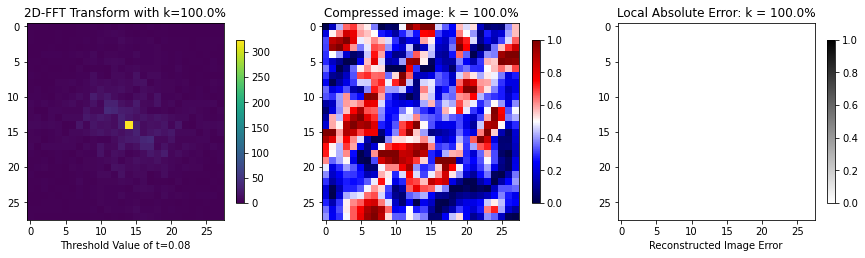

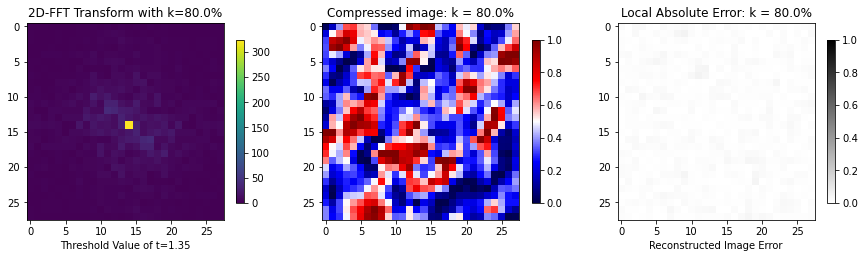

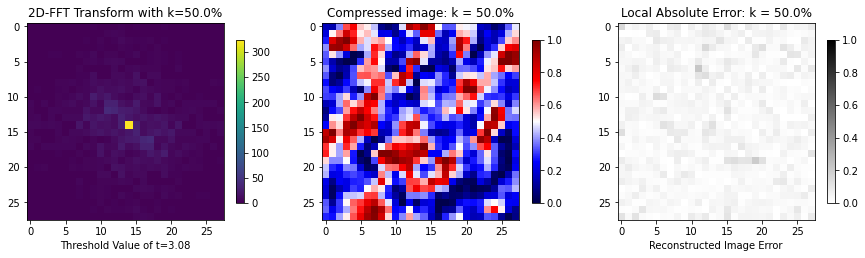

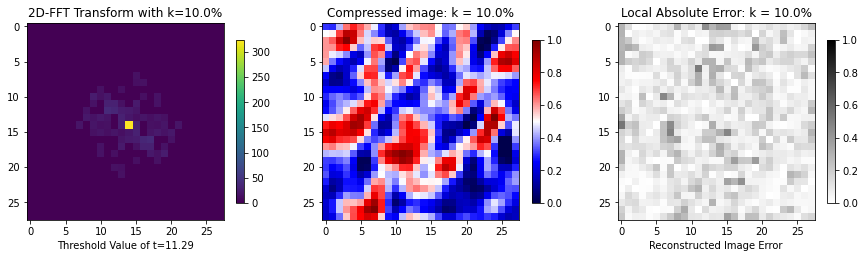

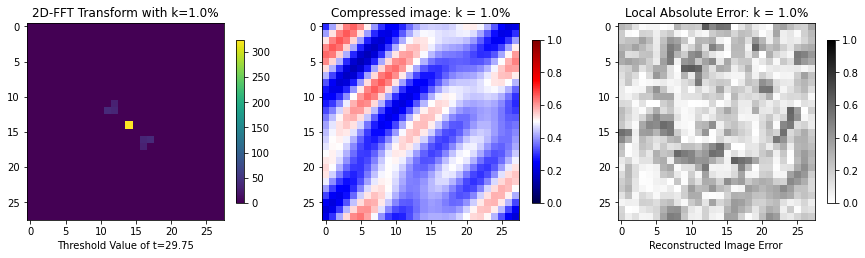

In [27]:
#img_fft2      - compute 2D FFT (column-wiseFFT(row-wiseFFT(image)))
#img_fft_shift - shifted zero-frequency component to the center of the spectrum. 

# flatten to 28x28=784 and sort according to the absolute magnitude
img_fft2_sort = np.sort(np.abs(img_fft2.reshape(-1)))

#zero out all small coefficients and inverse transform
mse = {}; ssim = {}
ks = np.array([100, 80, 50, 10, 1]) / 100    #percent coefficients kept
for k in ks:
    threshold  = img_fft2_sort[int(np.floor((1-k)*len(img_fft2_sort)))]    
    img_fft2_t = img_fft2 * (np.abs(img_fft2) > threshold)  
    
    # center-shift FFT
    img_fft2_t_c = SHIFT(img_fft2_t)

    # inverse FFT to reconstruct image
    img_ifft = iFFT2(img_fft2_t).real
    
    # error computations
    y  = img_gsc.reshape(-1)   #true image
    y_ = img_ifft.reshape(-1)  #reconstructed image
    if y.shape[0] == y_.shape[0]:
        n = y.shape[0]
    else: 
        print('error in lengths')
        break 
    mse[k]  = mean_squared_error(y, y_)
    ssim[k] = SSIM(img_gsc, img_ifft)
    
    # create plots
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))
    
    A = ax1.imshow(np.abs(img_fft2_t_c), cmap='viridis')
    ax1.set_title("2D-FFT Transform with k={}%".format(k*100))
    ax1.set_xlabel("Threshold Value of t={:.2f}".format(threshold))
    plt.colorbar(A, ax=ax1, shrink=0.6)
    
    B = ax2.imshow(img_ifft, vmin=0, vmax=1,
                    cmap=my_maps[features.index(feature_selected)])
    ax2.set_title("Compressed image: k = {}%".format(k*100))
    plt.colorbar(B, ax=ax2, shrink=0.6)
    
    C = ax3.imshow(np.abs(y-y_).reshape(dim1,dim2), cmap='binary', vmin=0, vmax=1)
    ax3.set_title('Local Absolute Error: k = {}%'.format(k*100))
    ax3.set_xlabel('Reconstructed Image Error')
    plt.colorbar(C, ax=ax3, shrink=0.6)
    
# unpack errors
list_mse, list_ssim  = sorted(mse.items()), sorted(ssim.items())  
x, y  = zip(*list_mse)
w, v  = zip(*list_ssim)         

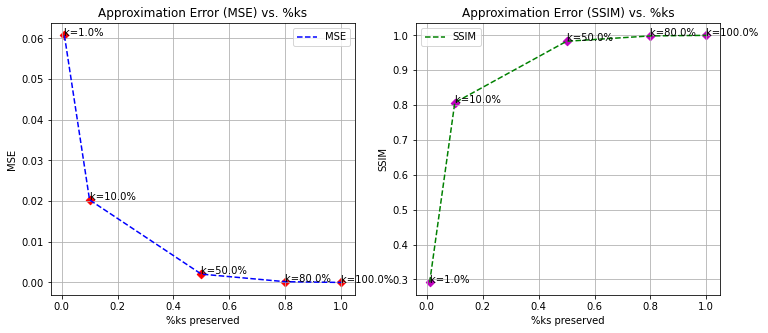

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(x,y,'b--', label="MSE")
plt.scatter(x,y, marker='D', c='r')
for i in range(len(ks)):
    plt.text(x[-i-1],y[-i-1],'k={}% '.format(100*ks[i]))
plt.title('Approximation Error (MSE) vs. %ks')
plt.legend(); plt.grid('on')
plt.xlabel('%ks preserved'); plt.ylabel('MSE')

plt.subplot(122)
plt.plot(w,v,'g--', label="SSIM")
plt.scatter(w,v, marker='D', c='m')
for i in range(len(ks)):
    plt.text(w[-i-1],v[-i-1],'k={}% '.format(100*ks[i]))
plt.title('Approximation Error (SSIM) vs. %ks')
plt.legend(); plt.grid('on')
plt.xlabel('%ks preserved'); plt.ylabel('SSIM')

plt.show();

We see that keeping about 50% or so of the information will result in a really good reconstruction with the decrease in MSE proportional to the compression ratio.

Next, we will retain about 50% of the coefficients and perform FFT, center shift, and iFFT to our subsurface feature and observe the reconstruction performance. we see that the MSE is approximately 0.002, and the SSIM is apprixamtely 98.3%, extremely good!

In [29]:
# compute 2D FFT (column-wiseFFT(row-wiseFFT(image)))
img_fft2 = FFT2(img_gsc)

# shift the zero-frequency component to the center of the spectrum. 
img_fft_shift = SHIFT(img_fft2)

# Define central 14x14 matrix to retain 50% of the coefficients
retain_index = 14
retain = np.arange((dim1-1)/2-retain_index/2+1, (dim1-1)/2+retain_index/2+2, dtype=int)
retain_first, retain_last = retain[0],  retain[-1]
print('Retain first, last:',retain_first, retain_last)

# Create matrix with all zeros except for central 8x8 square retained
center_fft = img_fft_shift[retain_first:retain_last , retain_first:retain_last]
center_mat = np.zeros((28,28), dtype=np.complex_)
center_mat[retain_first:retain_last,retain_first:retain_last] = center_fft

# inverse shift 
img_fft_ishift = iSHIFT(center_mat)

# Reconstruct using Inverse FFT
img_ifft = iFFT2(center_mat)

Retain first, last: 7 21


C:\Users\Misael Morales\AppData\Local\Temp\ipykernel_39552\4199098454.py:22: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(center_mat)),cmap=cmap)
C:\Users\Misael Morales\AppData\Local\Temp\ipykernel_39552\4199098454.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(img_fft_ishift)),cmap=cmap)


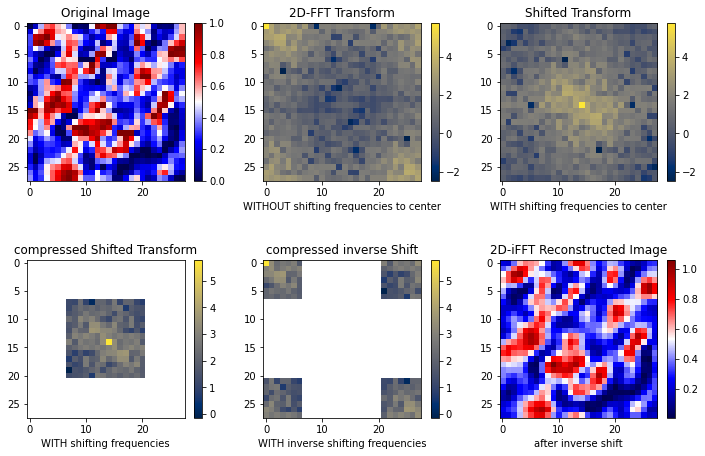

In [30]:
# plot the DFT (2D FFT) Transform (w/out centering)
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.imshow(img_gsc, cmap=my_maps[features.index(feature_selected)])
plt.title('Original Image')
plt.colorbar(shrink=0.8)

plt.subplot(232)
plt.imshow(np.log(np.abs(img_fft2)), cmap=cmap)
plt.title('2D-FFT Transform')
plt.xlabel('WITHOUT shifting frequencies to center')
plt.colorbar(shrink=0.8)

plt.subplot(233)
plt.imshow(np.log(np.abs(img_fft_shift)),cmap=cmap)
plt.title('Shifted Transform')
plt.xlabel('WITH shifting frequencies to center')
plt.colorbar(shrink=0.8)

plt.subplot(234)
plt.imshow(np.log(np.abs(center_mat)),cmap=cmap)
plt.title('compressed Shifted Transform')
plt.xlabel('WITH shifting frequencies')
plt.colorbar(shrink=0.8)

plt.subplot(235)
plt.imshow(np.log(np.abs(img_fft_ishift)),cmap=cmap)
plt.title('compressed inverse Shift')
plt.xlabel('WITH inverse shifting frequencies')
plt.colorbar(shrink=0.8)

plt.subplot(236)
plt.imshow(np.abs(img_ifft),cmap=my_maps[features.index(feature_selected)])
plt.title('2D-iFFT Reconstructed Image')
plt.xlabel('after inverse shift')
plt.colorbar(shrink=0.8)

plt.show();

In [31]:
# Error metrics for selected level of k~50%
mse  = mean_squared_error(img_gsc.reshape(-1) , np.abs(img_ifft).reshape(-1))
ssim = SSIM(img_gsc, np.abs(img_ifft))
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.011 | SSIM=0.908


### 5. Discrete Wavelet Transform

Similar to the Discrete Fourier Transform, the Discrete Wavelet Transform is creates a generic basis (unlike data-driven or tailored basis techniques) to encode the data into a reduced-dimensional representation. 

Going beyond the Fourier transform, where data is shifted from a time-space to a frequency-wavenumber domain, the Wavelet Transform allows for multi-resolution and spatiotemporal analysis. This allows to encode information about spatial features in the function and to exploit multi-resolution decomposition. In general, it allows for adaptive time/frequency resolution in different frequency bands for localized information. This is done by a windowed or block pattern from low to high spatial resolutions via the application of (high-pass/low-pass) filters.

In general, the wavelet system is constructed as a 2D-expansion for time-frequency localization as follows using an array of two-dimensional coefficients:
$$ f(t) = \sum_{k}\sum_{j} a_{j,k} \psi_{j,k} (t) \quad \psi_{j,k}(t): j,k=1,2,3,\dots $$

A system is derived from the "generating wavelet" by simple scaling and translation, and filter banks can be implemented through tree-structed algorithms for lower-resolution coefficients from high-resolution coefficients. The generating wavelet can be represented as:
$$ \psi_{a,b}(t) = \frac{1}{\sqrt{a}}\psi(\frac{t-b}{a}) $$
where $a$ represents the scaling parameter and $b$ the shift/translation parameter. The shifted and scaled functions form the basis of the multi-resolution representation, and if they're orthogonal then we can write a projection using the inner products.

The Continuous Wavelet Transform is given by:
$$ \mathcal{W}_\psi(f)(a,b) = \langle f, \psi_{a,b} \rangle = \int_{-\infty}^{\infty} f(t) \bar \psi_{a,b}(t) dt $$

In the discrete system, we can represent the Scaling and Wavelet functions as:
$$ x_{v,j}(t) = \sum_{k} \alpha_{j}(k)\phi_{jk}(t) \quad \& \quad x_{w,j}(t) = \sum_{k}\beta_{j}(k)\psi_{jk}(t) $$

Now we can represent the signal as a linear combination of the Scaling and Wavelet functions as:
$$ f(t) = \sum_{k=-\infty}^{\infty}\alpha_{k}\phi(t-k) + \sum_{k=-\infty}^{\infty} \sum_{j=0}^{\infty} \beta_{j,k} \psi(2^jt-k) $$
or
$$ f(t) = \sum_{j,k=-\infty}^{\infty} \langle f(t), \psi_{j,k}(t) \rangle \bullet \psi_{j,k}(t) $$

Important characteristics of the DWT include: (1) fast decay rate of the expansion coefficeints for large signals, (2) accurate description of local features, (3) adaptability to different types of wavelets, and (4) efficient implementation; but can be difficulty to exploit ill-posed inverse problems due to the lack of sensitivity to details in local features (high frequencies) in these situations.

In [32]:
# 2D Discrete Wavelet Transform

#parameters
wavelet = 'db1'    #generating wavelet
level   = 4        #wavelet bank levels
axes_wt = (-2,-1)  #DWT axes

#2D Wavelet Transform
coeffs = DWT2(x_train_gsc,
                wavelet=wavelet, level=level,
                axes=axes_wt)

#print shape of the DWT coefficients
print('original image shape', x_train_gsc.shape)
print('coeffs[0].shape', coeffs[0].shape)
for i in range(level):
    for j in range(3):
        print('coeffs[%d][%d].shape:' %(i+1,j), coeffs[i+1][j].shape)                             

original image shape (5000, 28, 28)
coeffs[0].shape (5000, 2, 2)
coeffs[1][0].shape: (5000, 2, 2)
coeffs[1][1].shape: (5000, 2, 2)
coeffs[1][2].shape: (5000, 2, 2)
coeffs[2][0].shape: (5000, 4, 4)
coeffs[2][1].shape: (5000, 4, 4)
coeffs[2][2].shape: (5000, 4, 4)
coeffs[3][0].shape: (5000, 7, 7)
coeffs[3][1].shape: (5000, 7, 7)
coeffs[3][2].shape: (5000, 7, 7)
coeffs[4][0].shape: (5000, 14, 14)
coeffs[4][1].shape: (5000, 14, 14)
coeffs[4][2].shape: (5000, 14, 14)


In [33]:
# copy coefficients for reconstruction
coeffs_recons = copy.deepcopy(coeffs)

#normalize by each level
coeffs[0] =  coeffs[0] / np.abs(coeffs[0]).max()
for lvl in range(level):
    coeffs[lvl + 1] = [c/np.abs(c).max() for c in coeffs[lvl + 1]]

#arrange wavelet coefficient into a single array
coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)
print('Coefficient Array Shape', coeff_arr.shape)

#flatten and sort according to magnitude
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))
print('Sorted Coefficient Array Shape', coeff_sort.shape)

#inverse DWT with all coefficients
coeffs_t        = array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
x_train_dwt_hat = iDWT2(coeffs_t, wavelet=wavelet)

Coefficient Array Shape (5000, 29, 29)
Sorted Coefficient Array Shape (4205000,)


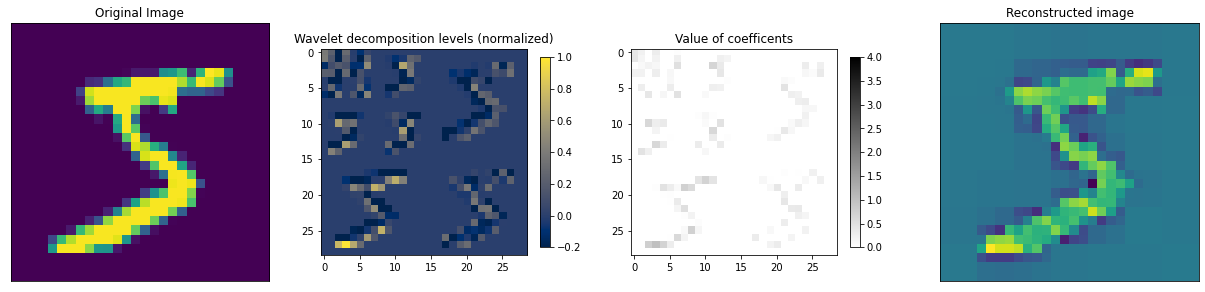

In [34]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(12,5))
plt.subplots_adjust(right=1.5)

A = ax1.imshow(x_train[0,:,:], cmap='viridis')
ax1.set_title('Original Image')
ax1.set_xticks([]); ax1.set_yticks([])

B = ax2.imshow(coeff_arr[0,:,:], cmap='cividis', vmin=-0.2, vmax=1.0)
plt.colorbar(B, ax=ax2, shrink=0.7)
ax2.set_title("Wavelet decomposition levels (normalized)")

# Plot the wavelet decomposition coefficient values
rs_coeff_arr = np.reshape(coeff_arr.reshape(-1), [N, coeff_arr.shape[1], coeff_arr.shape[2]])
C = ax3.imshow(rs_coeff_arr[0,:,:], cmap='binary', vmin=0, vmax=4)
plt.colorbar(C, ax=ax3, shrink=0.7)
ax3.set_title("Value of coefficents")

#Plot the reconstructed image
D = ax4.imshow(x_train_dwt_hat[0,:,:], cmap='viridis')
ax4.set_title('Reconstructed image')
ax4.set_xticks([]); ax4.set_yticks([])

plt.show();

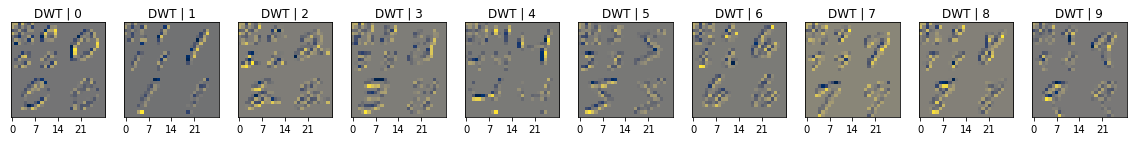

In [35]:
# Plot the DWT coefficients for each digit
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(1,len(np.unique(y_train)),i+1)
    plt.imshow(coeff_arr[y_train==i][0], cmap='cividis')
    plt.title('DWT | %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

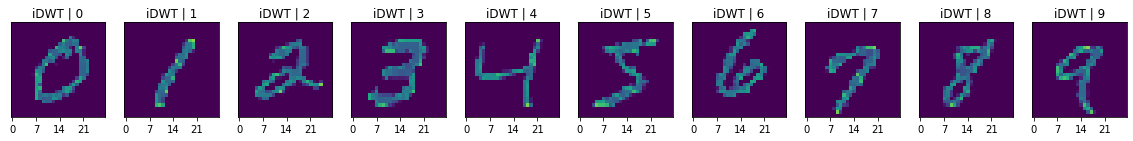

In [36]:
# Plot the first instance of each digit from the inverse DWT reconstruction
plt.figure(figsize=(20,8))
for i in np.unique(y_train):
    plt.subplot(1,len(np.unique(y_train)),i+1)
    plt.imshow((x_train_dwt_hat[y_train==i][0]), vmin=0, vmax=1, cmap='viridis')
    plt.title('iDWT | %i' %i); plt.xticks([0,7,14,21]); plt.yticks([])
plt.show();

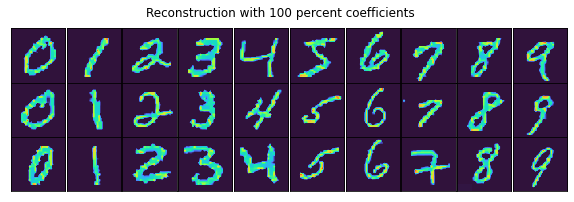

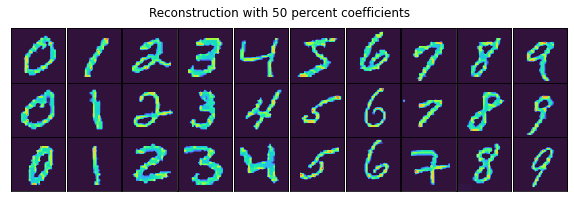

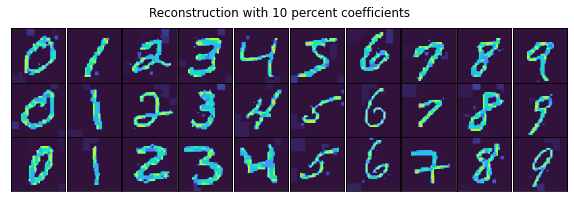

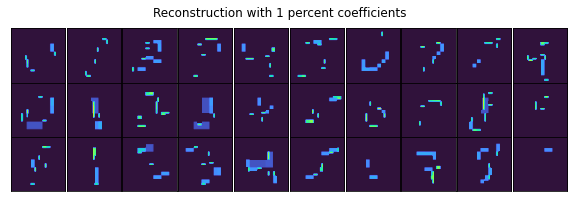

In [37]:
ks = np.array([100, 50, 10, 1]) / 100
for k in ks:
    threshold   = coeff_sort[int(np.floor((1-k)*len(coeff_sort)))]
    coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)

    coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')

    x_train_hat = iDWT2(coeffs_t, wavelet=wavelet)


    fig = plt.figure(figsize=(10, 3), constrained_layout=False)
    fig.suptitle('Reconstruction with %.0f' %(100*k) +' percent coefficients')
    outer_grid = fig.add_gridspec(1, 1, wspace=0.1, hspace=0)
    main_grid = outer_grid[0, 0].subgridspec(3, 10, wspace=0, hspace=0)
    axs = main_grid.subplots() 
    for (c,d), ax in np.ndenumerate(axs):
        ax.imshow(x_train_hat[y_train==d][c], cmap='turbo', vmin=0, vmax=1) 
        ax.set(xticks=[], yticks=[])

***

**Subsurface Discrete Wavelet Transform**

In [38]:
# 2D Discrete Wavelet Transform

#parameters
wavelet = 'db1'    #generating wavelet
level   = 4        #wavelet bank levels

#2D Wavelet Transform
coeffs = DWT2(img_gsc, wavelet=wavelet, level=level)

#print shape of the DWT coefficients
print('original image shape', x_train_gsc.shape)
print('coeffs[0].shape', coeffs[0].shape)
for i in range(level):
    for j in range(3):
        print('coeffs[%d][%d].shape:' %(i+1,j), coeffs[i+1][j].shape)                             

original image shape (5000, 28, 28)
coeffs[0].shape (2, 2)
coeffs[1][0].shape: (2, 2)
coeffs[1][1].shape: (2, 2)
coeffs[1][2].shape: (2, 2)
coeffs[2][0].shape: (4, 4)
coeffs[2][1].shape: (4, 4)
coeffs[2][2].shape: (4, 4)
coeffs[3][0].shape: (7, 7)
coeffs[3][1].shape: (7, 7)
coeffs[3][2].shape: (7, 7)
coeffs[4][0].shape: (14, 14)
coeffs[4][1].shape: (14, 14)
coeffs[4][2].shape: (14, 14)


In [39]:
#normalize by each level
coeffs[0] =  coeffs[0] / np.abs(coeffs[0]).max()
for lvl in range(level):
    coeffs[lvl + 1] = [c/np.abs(c).max() for c in coeffs[lvl + 1]]

#arrange wavelet coefficient into a single array
coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)
print('Coefficient Array Shape', coeff_arr.shape)

#flatten and sort according to magnitude
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))
print('Sorted Coefficient Array Shape', coeff_sort.shape)

#inverse DWT with all coefficients
coeffs_t      = array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
img_dwt_hat   = iDWT2(coeffs_t, wavelet=wavelet)
img_dwt_hat_f = np.ravel(img_dwt_hat)  #flaattened

Coefficient Array Shape (29, 29)
Sorted Coefficient Array Shape (841,)


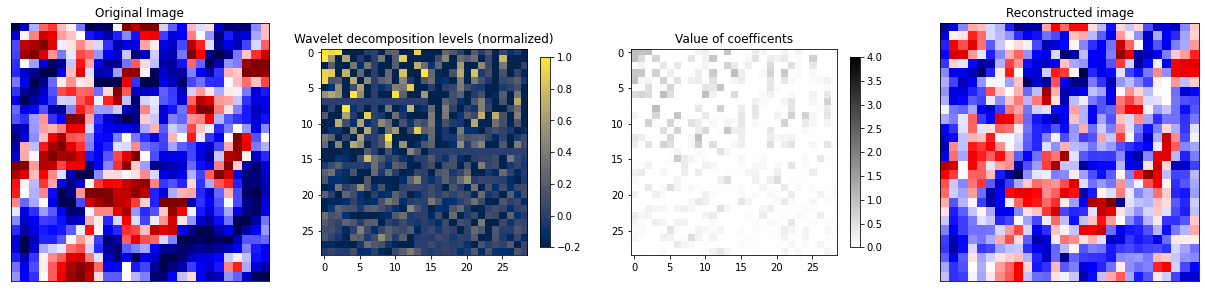

In [40]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(12,5))
plt.subplots_adjust(right=1.5)

A = ax1.imshow(img_gsc, cmap=my_maps[features.index(feature_selected)])
ax1.set_title('Original Image')
ax1.set_xticks([]); ax1.set_yticks([])

B = ax2.imshow(coeff_arr, cmap='cividis', vmin=-0.2, vmax=1.0)
plt.colorbar(B, ax=ax2, shrink=0.7)
ax2.set_title("Wavelet decomposition levels (normalized)")

# Plot the wavelet decomposition coefficient values
rs_coeff_arr = np.reshape(coeff_arr.reshape(-1), [coeff_arr.shape[0], coeff_arr.shape[1]])
C = ax3.imshow(rs_coeff_arr, cmap='binary', vmin=0, vmax=4)
plt.colorbar(C, ax=ax3, shrink=0.7)
ax3.set_title("Value of coefficents")

#Plot the reconstructed image
D = ax4.imshow(img_dwt_hat, cmap=my_maps[features.index(feature_selected)])
ax4.set_title('Reconstructed image')
ax4.set_xticks([]); ax4.set_yticks([])

plt.show();

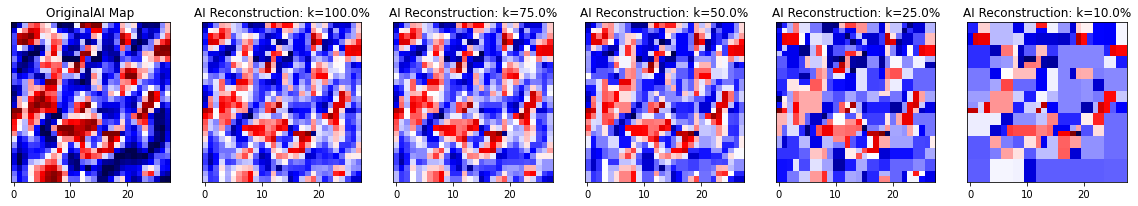

In [41]:
ks = np.array([100, 75, 50, 25, 10]) / 100

plt.figure(figsize=(20,5))
plt.subplot(1, len(ks)+1, 1)
plt.imshow(img_gsc, cmap=my_maps[features.index(feature_selected)])
plt.title('Original'+feature_selected+' Map')
plt.yticks([])

it = 0
for k in ks:
    threshold   = coeff_sort[int(np.floor((1-k)*len(coeff_sort)))]
    coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)

    #pass array to coefficients
    coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')

    #do inverse DWT
    x_train_hat = iDWT2(coeffs_t, wavelet=wavelet)

    #plot reconstructed images
    plt.subplot(1, len(ks)+1, it+2)
    plt.imshow(x_train_hat, cmap=my_maps[features.index(feature_selected)])
    plt.title(feature_selected+' Reconstruction: k='+str(100*k)+'%')
    plt.yticks([])

    it+=1

We observe using only 10% of the wavelet coefficients will not suffice to efficiently reconstruct the subsurface feature map, however, with 25% we can observe the general shape of the feature, and using 50-75% of the wavelet coefficients we can get a really good reconstruction of the image. 

***

### Results and Discussion

DFT:
- DFT via FFT is very widely-used and can be applied to a large set of problems in science and engineering, including 2D/3D problems such as subsurface images/volumnes, and dynamic problems such as reservoir simulation. It has been used to find parameterization, clustering and inference, and of course dimensionality reduction.
- DFT can be dervied mathematically from an infinite expansion of the given function/signal around a sine and cosine basis.
- This method is applicable to any data and does not require data-driven tailored basis.

DWT:
- DWT incorporates local information via multi-resolution basis of the given signal or image. This allows for spatiotemporal analysis and adaptive time/frequency resolution via filter banks.
- A generating wavelet is required, and along with the scaling and translation parameter can form the basis for dimensionality reduction for any signal or image.
- This method is also applicable to any data and also does not require data-driven tailored basis.

Important Notes:
- The MNIST dataset has the digits centered at the image. Therefore, we using the learned basis from this generic dataset, our subsurface image reconstructions will be most accurate near the center and quite bad near the edges. If we increase the dimension of the latent space, we start to gather information of the edges (which is irrelevant for MNIST but relevant for subsurface maps). Therefore, for this particular transfer learning problem, we might need to use more latent variables than desired. Using a different generic dataset with more information near the edges to learn the sparse encoding might help in transfer reconstruction.

MNIST:
- Using DFT and DWT, we see that approximately 50% of latent variables will suffice to encode the MNIST images (28x28=784). For MNIST compression and reconstruction, our experiment shows that just half of the latent variables are sufficient to obtain a very good MNIST reconstruction, with approximately MSE=0.023 and SSIM=0.808! 

Subsurface:
- With DFT/DWT we obtained a set of coefficient that efficiently encode the image into a latent dimension. Using the inverse decomposition we could then reconstruct this compressed subsuface image, and saw that using only again only 50% of the coefficients our reconstruction was extremely efficient. Using all the coefficients, our SSIM was 1.00. Nonetheless, computational complexity and costs are really low for this technique.

Conclusions:
- Classical (non data-drive) basis are a very powerful and useful techniques for dimensionality reduction and image compression/reconstruction problems. They can also be used for other latent space applications such as clustering, parameter estimation, and more.

- MSE and SSIM provide useful measures for the goodness-of-fit and validity of our reconstructions. SSIM is especially useful when dealing with image datasets, and compares the mean and variance of a set of prior and posterior images. We see that for our experiment, MSE is low and SSIM is high when we try to reconstruct MNIST images from a latent dimension using MNIST basis, but we see medium MSE and SSIM (acceptable but not excellent) when reconstructing subsurface images from MNIST basis.

### References:
1. Killough, J.E., and M.F. Wheeler. "Parallel Iterative Linear Equation Solvers: An Investigation of Domain Decomposition Algorithms for Reservoir Simulation." Paper presented at the SPE Symposium on Reservoir Simulation, San Antonio, Texas, February 1987. doi: https://doi.org/10.2118/16021-MS
2. Cai, X, BF Nielsen, and A Tveito. “An Analysis of a Preconditioner for the Discretized Pressure Equation Arising in Reservoir Simulation.” IMA journal of numerical analysis 19.2 (1999): 291–316.
3. Mudunuru, Maruti Kumar, et al. "Physics-informed machine learning for real-time unconventional reservoir management." LA-UR-19-31611. Los Alamos National Lab.(LANL), Los Alamos, NM (United States), 2020.
4. Li, Lianlin, and Behnam Jafarpour. "Effective solution of nonlinear subsurface flow inverse problems in sparse bases." Inverse Problems 26.10 (2010): 105016.
5. Sahni, Isha, and Roland N. Horne. "Multiresolution wavelet analysis for improved reservoir description." SPE Reservoir Evaluation & Engineering 8.01 (2005): 53-69.

6. Brunton, S., & Kutz, J. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge: Cambridge University Press.
7. Murphy, K. P. (2012). Machine Learning: A Probabilistic Perspective. United States: MIT Press.
8. Phillips, J. M. (2021). Mathematical Foundations for Data Analysis. Germany: Springer International Publishing.
9. Verleysen, M., Lee, J. A., Lee, J. A. (2007). Nonlinear Dimensionality Reduction. Netherlands: Springer New York.
10. Wang, J. (2012). Geometric Structure of High-Dimensional Data and Dimensionality Reduction. Germany: Higher Education Press.
11. Pyrcz, M. J., Deutsch, C. V. (2014). Geostatistical Reservoir Modeling. United Kingdom: Oxford University Press.

***

### About Me

I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, and I am supervised by Drs. Pyrcz and Torres-Verdin. My background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa. I am originally from Venezuela!

At UT, I am working on the computational description of subsurface energy and environmental systems. I combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. My work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy. My focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.


* More workflows to come on other advanced dimensionality reduction techniques!
    * PCA/kPCA, SVD, Dictionary Learning, DFT/DCT/DWT, POD/DMD, Deep Learning-based AutoEncoders, ... 
* Also working on subsurface problems including machine learning & data science applications for reservoir modeling & simulation.
    * Uncertainty quantification, data assimilation, control & optimizaiton, inverse & reduced-order modeling! 

I hope this was helpful,

**Misael M. Morales**
#### [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)

# END